In [1]:
from typing import Union
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import SGDOneClassSVM
from sklearn.preprocessing import StandardScaler


In [49]:
pip install pandas scikit-learn numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
RANDOM_SEED = 42
DATA_PATH = Path("../data")

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


In [4]:
train_data = pd.read_csv(DATA_PATH / "train.csv")
test_data = pd.read_csv(DATA_PATH / "test.csv")

In [5]:
print(train_data.shape)
test_data.shape

(250000, 55)


(710400, 54)

In [7]:
train_data.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [6]:
train_standard = StandardScaler().fit_transform(train_data)
test_standard = StandardScaler().fit_transform(test_data)


In [7]:
# 2. K-means 모델 학습 (Train 데이터로 학습)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(train_standard)

# 3. Test 데이터에 대한 예측 수행
test_cluster_labels = kmeans.predict(test_standard)

# 4. 각 샘플과 해당 군집 중심 간 거리 계산
distances = np.linalg.norm(test_standard - kmeans.cluster_centers_[test_cluster_labels], axis=1)

# 5. 임계값 설정 (Train 데이터의 95% 백분위수 사용)
train_distances = np.linalg.norm(train_standard - kmeans.cluster_centers_[kmeans.labels_], axis=1)
threshold = np.percentile(train_distances, 95)

# 6. 비정상 탐지: 임계값 초과 시 비정상(1), 이하 시 정상(0) 예측
predicted_labels = (distances > threshold).astype(int)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: X has 54 features, but KMeans is expecting 55 features as input.

In [53]:
print(f"Test Data Prediction (0=Normal, 1=Anomaly):\n{predicted_labels}")

Test Data Prediction (0=Normal, 1=Anomaly):
[1 1 1 ... 0 0 0]


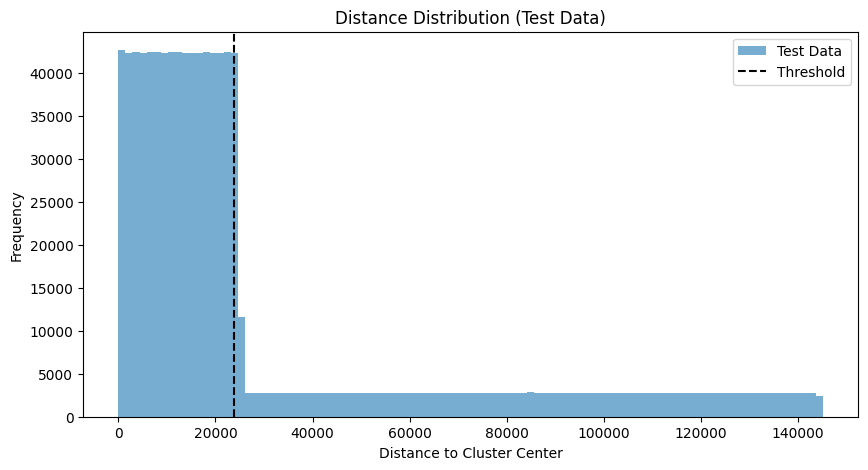

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(distances, bins=100, alpha=0.6, label='Test Data')
plt.axvline(threshold, color='k', linestyle='--', label='Threshold')
plt.legend()
plt.title('Distance Distribution (Test Data)')
plt.xlabel('Distance to Cluster Center')
plt.ylabel('Frequency')
plt.show()

In [8]:
train_data['num'] = (train_data['simulationRun']-1)*500+train_data['sample']

In [26]:
train_data=train_data.drop(columns=['simulationRun','sample'])

In [27]:
train_data.tail()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11,num
249995,0.29325,3640.1,4473.0,9.1949,26.867,42.379,2700.2,75.533,120.41,0.34050,...,29.249,60.773,21.532,40.451,34.064,48.953,48.291,40.812,18.756,249996.0
249996,0.29134,3625.7,4506.2,9.2109,26.889,42.291,2700.6,75.935,120.39,0.35374,...,28.975,61.517,21.750,42.762,42.645,51.055,48.589,40.933,19.360,249997.0
249997,0.29438,3600.2,4478.3,9.1957,26.820,42.448,2700.3,74.706,120.41,0.35910,...,28.676,61.656,21.487,42.109,39.770,46.770,48.648,41.465,19.344,249998.0
249998,0.25269,3683.5,4486.4,9.2832,27.188,42.757,2697.4,75.101,120.39,0.32469,...,24.889,61.564,21.392,39.334,42.274,43.623,48.797,39.835,18.512,249999.0
249999,0.25214,3648.2,4467.8,9.1344,26.886,42.534,2695.1,74.787,120.41,0.32751,...,24.943,61.254,21.208,38.991,42.873,44.400,48.876,41.076,16.158,250000.0


In [34]:
train_data.columns

Index(['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6',
       'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12',
       'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18',
       'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24',
       'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30',
       'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
       'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1',
       'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9',
       'xmv_10', 'xmv_11', 'num'],
      dtype='object')

In [16]:
test_data['num'] = (test_data['simulationRun']-1)*500+test_data['sample']

In [28]:
test_data=test_data.drop(columns=['simulationRun','sample'])

In [35]:
test_data=test_data[['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6',
       'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12',
       'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18',
       'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24',
       'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30',
       'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
       'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1',
       'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9',
       'xmv_10', 'xmv_11', 'num']]

In [36]:
test_data.head()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11,num
0,0.24927,3629.5,4517.9,9.3652,26.986,42.606,2705.0,75.255,120.41,0.33775,...,24.767,62.495,22.050,39.987,38.451,47.832,47.427,40.319,16.011,75001
1,0.25248,3667.9,4513.8,9.4400,26.811,42.131,2704.3,75.795,120.41,0.33964,...,24.452,58.961,21.920,39.756,36.490,50.014,47.059,41.286,20.370,75002
2,0.25116,3634.7,4480.6,9.4904,27.234,42.224,2704.3,74.874,120.38,0.33801,...,24.588,60.385,22.270,39.954,33.784,50.440,47.592,41.210,16.036,75003
3,0.24815,3649.7,4493.3,9.1957,27.102,42.115,2704.1,75.118,120.39,0.33556,...,24.885,63.593,22.068,40.253,32.951,45.397,47.591,41.183,15.611,75004
4,0.23961,3705.7,4487.8,9.2651,26.790,42.391,2703.9,75.370,120.41,0.32149,...,23.879,61.476,21.861,38.217,33.422,45.579,47.524,41.701,16.618,75005


In [33]:
test_data.columns

Index(['xmeas_1', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
       'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_2',
       'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25',
       'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_3', 'xmeas_30',
       'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
       'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_4', 'xmeas_40', 'xmeas_41',
       'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmv_1',
       'xmv_10', 'xmv_11', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6',
       'xmv_7', 'xmv_8', 'xmv_9', 'num'],
      dtype='object')

In [ ]:
train_data

In [12]:
kmeans = KMeans(n_clusters=5, random_state=42)  # 5개의 군집으로 학습

In [39]:
test_data = np.vstack([train_data, test_data])

In [30]:
kmeans.fit(train_data)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=42)

In [43]:
cluster_labels = kmeans.predict(test_data)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [45]:
distances = np.linalg.norm(test_data - kmeans.cluster_centers_[cluster_labels], axis=1)

In [46]:
threshold = np.percentile(distances[:250000], 95)

In [47]:
predicted_labels = (distances > threshold).astype(int)

In [48]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Anomaly']))

NameError: name 'true_labels' is not defined